In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import shap
from shap import Explanation
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load data

In [3]:
# Load data
df = pd.read_csv('../data/clean_data.csv')

# Convert to datetime to avoid errors
df['activity_month'] = pd.to_datetime(df['activity_month'])
df['ftd_date'] = pd.to_datetime(df['ftd_date'])
df['qp_date'] = pd.to_datetime(df['qp_date'])

df.head()

,activity_month,account_id,brand_id,reg_date,ftd_date,qp_date,ben_login_id,tracker_id,player_reg_product,total_deposit,total_handle,total_ngr,months_active
0,2023-11-01,154497623,AZ,2022-10-28,2022-10-28,2022-10-28,actionnetwork,7039239,BETTING,0.0,5.0,4.00,13
1,2023-11-01,184718245,OH,2023-11-13,2023-11-13,2023-11-13,actionnetwork,7106987,BETTING,10.0,210.0,138.98,0
2,2023-11-01,183573211,OH,2023-11-06,2023-11-06,2023-11-06,BCUSA22NP,7106983,BETTING,10.0,210.0,-320.22,0
3,2023-11-01,153923970,PA,2022-09-12,2022-09-12,2022-09-12,BCUSA22N,7086406,CASINO,0.0,0.0,0.00,14
4,2023-11-01,174413334,TN,2023-10-05,2023-10-05,2023-11-21,BCUSA22N,7086400,BETTING,60.0,303.0,68.46,1


### 2. Feature engineering
From the first model, I'm going to use the churned variable to predict the churn rate by month. This rate will help me identify the months with the highest churn

In [4]:
# Define the target variable (Churn)
df['next_month'] = df.groupby('account_id')['activity_month'].shift(-1) # Identify if user was active in the next month
df['churned'] = (df['next_month'].isna()) | ((df['next_month'] - df['activity_month']) > pd.Timedelta(days=32)) # Identify if user churned
df = df.dropna(subset=['next_month']) # Remove the last month for each player (can't determine if they churned)

# Calculate churn rate by month
churn_rate_by_month = df.groupby('months_active')['churned'].mean()
churn_rate_by_month.head(5)

months_active
0    0.793255
1    0.723164
2    0.599455
3    0.591954
4    0.539185
Name: churned, dtype: float64

We already knew that churn was highest in the first couple of months, but with this rate we can see the percentage. 79% churned in the first month of activity, 72% in the second, 60% in the third, and so on. I think this last one makes the most sense to use as a threshold for two reasons:
1. Two months of activity is enough time to get data from players, but it's still early enough to predict churn
2. With ~60% churn / ~40% retention datapoints in the current dataset, we have a somewhat balanced dataset to train the model

In [5]:
# Get the rest of the variables from the first model
# Label encode categorical features identified in EDA
for col in ['brand_id', 'ben_login_id', 'player_reg_product']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Target encode tracker_id 
mean_churn_by_tracker = df.groupby('tracker_id')['churned'].mean()
df['tracker_id_encoded'] = df['tracker_id'].map(mean_churn_by_tracker)

df.head()

,activity_month,account_id,brand_id,reg_date,ftd_date,qp_date,ben_login_id,tracker_id,player_reg_product,total_deposit,total_handle,total_ngr,months_active,next_month,churned,tracker_id_encoded
4,2023-11-01,174413334,23,2023-10-05,2023-10-05,2023-11-21,2,7086400,0,60.0,303.0,68.46,1,2024-05-01,True,0.542453
5,2023-11-01,153776081,0,2022-09-10,2022-09-10,2022-09-15,5,7080479,0,0.0,170.0,136.00,14,2022-09-01,False,0.541063
11,2023-11-01,171348342,22,2023-09-25,2023-09-25,2023-09-25,5,7106940,0,0.0,4.4,0.01,2,2024-02-01,True,0.333333
23,2023-11-01,161464115,21,2022-12-25,2022-12-25,2023-01-01,4,7039239,0,0.0,26.0,11.96,11,2024-03-01,True,0.548387
24,2023-11-01,169240786,23,2023-09-15,2023-09-19,2023-10-13,4,7103466,0,100.0,80.0,53.80,2,2024-02-01,True,0.523810


Build new dataset aggregating by account_id and creating a new target variable (early_churn)

In [7]:
# Compute each user’s maximum active month
user_max_month = (
    df
    .groupby('account_id')['months_active']
    .max()
    .reset_index(name='max_month_active')
)

# Label early churn (1 if max_month_active ≤ 2, else 0)
user_max_month['early_churn'] = (user_max_month['max_month_active'] <= 2).astype(int)

# Aggregate features over the first 2 months (months_active 0, 1, 2)
agg_feats = (
    df[df['months_active'] <= 2]
    .groupby('account_id')
    .agg(
        total_deposit_2m =('total_deposit', 'sum'),
        total_handle_2m  =('total_handle',  'sum'),
        total_ngr_2m     =('total_ngr',     'sum'),
        months_active    =('months_active', 'max'),
        brand_id         =('brand_id',      'first'),
        tracker_id_enc   =('tracker_id_encoded', 'first'),
        product          =('player_reg_product',  'first'),
        ben_login_id     =('ben_login_id', 'first')
    )
    .reset_index()
)

# Merge labels and features
df_early = agg_feats.merge(
    user_max_month[['account_id', 'early_churn']],
    on='account_id',
    how='left'
)

df_early.head()

,account_id,total_deposit_2m,total_handle_2m,total_ngr_2m,months_active,brand_id,tracker_id_enc,product,ben_login_id,early_churn
0,150789529,10.00,60.00,-40.22,0,8,0.575758,0,4,1
1,150899797,1463.31,3010.89,-71.32,1,20,0.581967,0,4,1
2,150931859,250.00,447.56,351.11,0,2,0.543046,0,3,0
3,150970490,0.00,86.50,7.79,1,14,0.452830,1,1,0
4,150975813,106.00,152.67,43.56,1,8,1.000000,0,5,1


### 3. Modeling
I also chose XGBoost for the mentioned reasons on the baseline model

In [8]:
features = df_early.columns.drop(['account_id','early_churn']).tolist()


# Define X and y
X = df_early[features]
y = df_early['early_churn'].astype(int)

# Split the data (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [9]:
features

['total_deposit_2m',
 'total_handle_2m',
 'total_ngr_2m',
 'months_active',
 'brand_id',
 'tracker_id_enc',
 'product',
 'ben_login_id']

In [10]:
xgb_model = XGBClassifier(
    eval_metric='auc',
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

ROC AUC: 0.559814376868502
Precision: 0.8210227272727273
Recall: 0.9413680781758957
Accuracy: 0.7868421052631579


<Figure size 600x600 with 0 Axes>

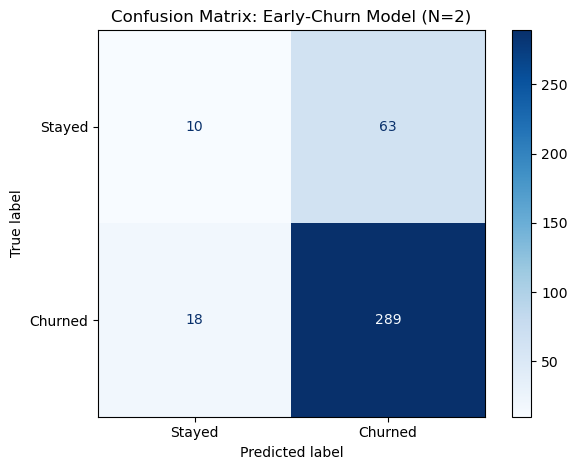

In [11]:
# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Get metrics
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Stayed', 'Churned']
)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Early‑Churn Model (N=2)")
plt.tight_layout()
plt.show()

The model achieved 0.56 AUC, so a little more over a random classifier. However, it captured 94% of churners (recall/sensitivity) with 82% precision. In order to improve these metrics, especially AUC, further feature engineering, hyperparameter tuning (gridsearch/optuna), and cross-validation would be needed

### 4. SHAP Analysis
Just to compare with the previous model, I wanted to see what were the most important variables when predicting early churn

In [12]:
# Create the exaplainer using the trained model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

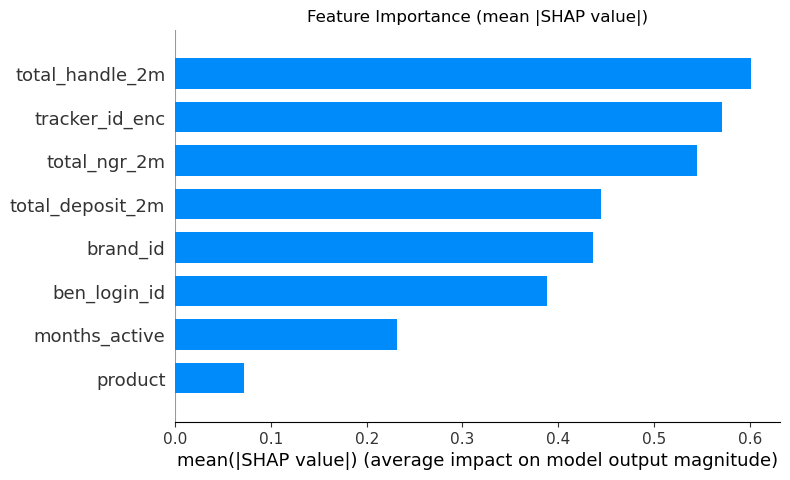

In [13]:
plt.figure(figsize=(8, 4))
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.tight_layout()
plt.title('Feature Importance (mean |SHAP value|)')
plt.show()

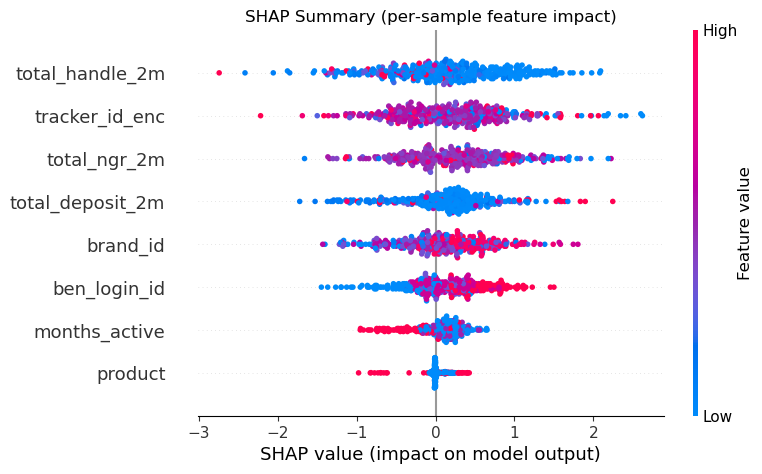

In [14]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.title('SHAP Summary (per‐sample feature impact)')
plt.show()

Very similar to the baseline model, the top 3 variables are the same, but in this model the contribution of each variable to the overall prediction is more balanced